# FIT 5149 Assessment 2 Electric Vehicle Charging: 
### author: 
### date:

## 1. Library import

In [13]:
import pandas as pd
import calplot
import seaborn as sns
import matplotlib.pyplot as plot

# from tsfresh import extract_features, extract_relevant_features, select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

from pylab import rcParams 
import statsmodels.api as sm 

import numpy as np

import warnings
warnings.filterwarnings("ignore")

import plotly.io as pio
pio.renderers.default='notebook'

## 2. Loading File

In [14]:
file = pd.read_csv('./train_data_withlabels.csv')
test_file = pd.read_csv('./test_data_nolabels.csv')

# 3.Exploratroy Data Analsysis

In [15]:
# Get the raw data
traditional_file = file[['dataid', 'localminute','total_load','target']]

## 3.1 Overview of the raw dataset

In [16]:
traditional_file

,dataid,localminute,total_load,target
0,1,2018-01-02 01:00:00,0.416,0
1,2,2018-01-02 01:01:00,0.416,0
2,3,2018-01-02 01:02:00,0.416,0
3,4,2018-01-02 01:03:00,0.415,0
4,5,2018-01-02 01:04:00,0.416,0
...,...,...,...,...
419803,419804,2018-10-20 13:43:00,0.703,0
419804,419805,2018-10-20 13:44:00,0.704,0
419805,419806,2018-10-20 13:45:00,0.700,0
419806,419807,2018-10-20 13:46:00,0.678,0


In [17]:
traditional_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419808 entries, 0 to 419807
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dataid       419808 non-null  int64  
 1   localminute  419808 non-null  object 
 2   total_load   419808 non-null  float64
 3   target       419808 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 12.8+ MB


In [18]:
# display the statistical information
traditional_file.describe()

,dataid,total_load,target
count,419808.000000,419808.000000,419808.000000
mean,209904.500000,1.138576,0.054411
std,121188.275241,1.551522,0.226826
min,1.000000,-4.780000,0.000000
25%,104952.750000,0.277000,0.000000
50%,209904.500000,0.414000,0.000000
75%,314856.250000,1.177000,0.000000
max,419808.000000,15.404000,1.000000


 According to the information displayed above, it could be observed that the column type of **localminute** and **total_load** should be converted to datetime and category. In addition, there are negative values in the **total_load** column, where negative values are not supposed to appear. As a result, we will make some data pre-processing measure to process the raw data.

### 3.1.1 Data Pre-processing

**Convert column type**

In [19]:
# convert integer to category
traditional_file.target = traditional_file.target.astype('category')

In [20]:
# convert the object to datetime 
traditional_file['localminute'] = pd.to_datetime(traditional_file['localminute'])

**Remove duplicate**

In [21]:
traditional_file.drop_duplicates()

,dataid,localminute,total_load,target
0,1,2018-01-02 01:00:00,0.416,0
1,2,2018-01-02 01:01:00,0.416,0
2,3,2018-01-02 01:02:00,0.416,0
3,4,2018-01-02 01:03:00,0.415,0
4,5,2018-01-02 01:04:00,0.416,0
...,...,...,...,...
419803,419804,2018-10-20 13:43:00,0.703,0
419804,419805,2018-10-20 13:44:00,0.704,0
419805,419806,2018-10-20 13:45:00,0.700,0
419806,419807,2018-10-20 13:46:00,0.678,0


**Convert the negative values to possitive values??? why**

In [22]:
# show the 
traditional_file['total_load'] = traditional_file['total_load'].abs()
# traditional_file[traditional_file['total_load'] <= 0]

In [23]:
traditional_file.describe()

,dataid,total_load
count,419808.000000,419808.000000
mean,209904.500000,1.168551
std,121188.275241,1.529073
min,1.000000,0.001000
25%,104952.750000,0.279000
50%,209904.500000,0.417000
75%,314856.250000,1.232000
max,419808.000000,15.404000


### 3.1.2 Analysis of univariate and bivariate

**Label Analysis**

In [24]:
# https://www.statology.org/seaborn-barplot-show-values/

# a function used to add values in the count plot
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

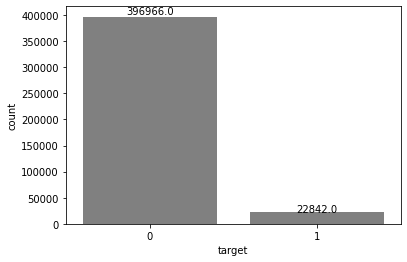

In [25]:
# Distribution of the label
p = sns.countplot(traditional_file['target'], color='gray')
show_values(p)

According to the plots displayed above, the charging time (target = 1) is **much longer than** the uncharging time(target = 0). ??补充？

**Total_Load Analysis**

<AxesSubplot:ylabel='Density'>

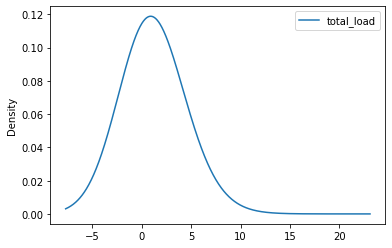

In [26]:
traditional_file[['total_load']].plot.kde(bw_method=2)#? 是否有别的选择

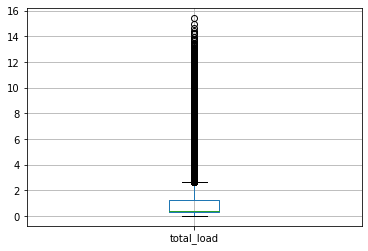

In [27]:
boxplot = traditional_file.boxplot(column=['total_load'])  

In [28]:
traditional_file[['total_load']].describe()

,total_load
count,419808.000000
mean,1.168551
std,1.529073
min,0.001000
25%,0.279000
50%,0.417000
75%,1.232000
max,15.404000


From the plot and table above, it could be observed that most of the values are distributed around the zero. In addition, from the boxplot, most of the values are between 0 and 2, **while the others are well beyond Q3 + 1.5IQR a lot**. In this case, we would like to look how many values exceeds the threshold, which will be illustrated as follow.

In [29]:
# get the number of values beyong Q3 + 1.5IQR
total_load_Q1 = traditional_file['total_load'].quantile(0.25)
total_load_Q3 = traditional_file['total_load'].quantile(0.75)
total_load_IQR = total_load_Q3 - total_load_Q1

# Get the dataframe that save the "outliers"
outliers_df = traditional_file.query('(@total_load_Q3 + 1.5 * @total_load_IQR) <= total_load ')

In [30]:
outliers_df

,dataid,localminute,total_load,target
1637,1638,2018-01-03 04:17:00,2.841,0
3999,4000,2018-01-04 19:39:00,4.606,0
4000,4001,2018-01-04 19:40:00,4.554,0
4001,4002,2018-01-04 19:41:00,4.562,0
4002,4003,2018-01-04 19:42:00,5.176,0
...,...,...,...,...
419788,419789,2018-10-20 13:28:00,3.007,0
419789,419790,2018-10-20 13:29:00,3.206,0
419792,419793,2018-10-20 13:32:00,5.094,0
419795,419796,2018-10-20 13:35:00,4.441,0


It could be observed that there are 83813 rows whose total_load exceeds the **Q3+1.5IQR**. Subsequently, we would like to know the distribution of target in this dataset in order to judge whether there is an relation between these two variables.

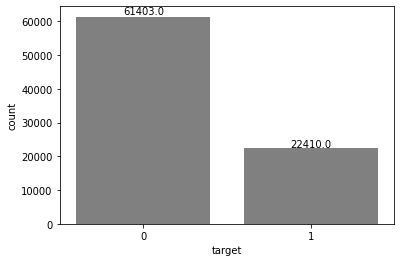

In [31]:
# Distribution of the label
p1 = sns.countplot(outliers_df['target'], color='gray')
show_values(p1)

From the target distribution in the raw data, there are total **22842** charging minutes. As a comparison, there are total **22410** charging minuts when the total load is beyond Q3+1.5IQR.In this case, we could assume there may have a **strong relation** between total_load and target label.

From the analysis illustrated above, we analyze the univariate varible and make some asssumption. After that, we will study the relationship between two or more varibles.

**Relationship between localminute and total_load**

In [32]:
tenp = traditional_file[['localminute','total_load']].groupby(pd.Grouper(key='localminute',freq="D")).mean()
dict1 = {}
j = 0
for i in tenp.index:
    dict1.update({i:float(tenp.values[j])})
    j+=1

new_temp = pd.DataFrame(list(dict1.items()),columns = ['localminute','total_load'])
groups = new_temp.groupby(pd.Grouper(key='localminute',freq="M"))
pd.Grouper
dict2 = {}
months = pd.DataFrame()
array = []
for name, group in groups:
    #years[name.month] = group
    for i in group.values.tolist():
        array.append(round(i[1],2))
    if len(array) <31:
        for i in range(31-len(array)):
            array.append(0.00)
    months[name.month] = array
    array = []

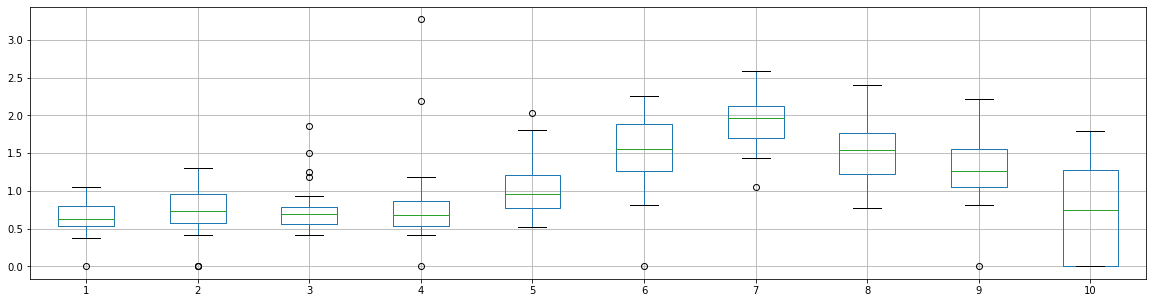

In [33]:
fig, ax = plot.subplots(1,1, figsize =(20,5))
ax = months.boxplot()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

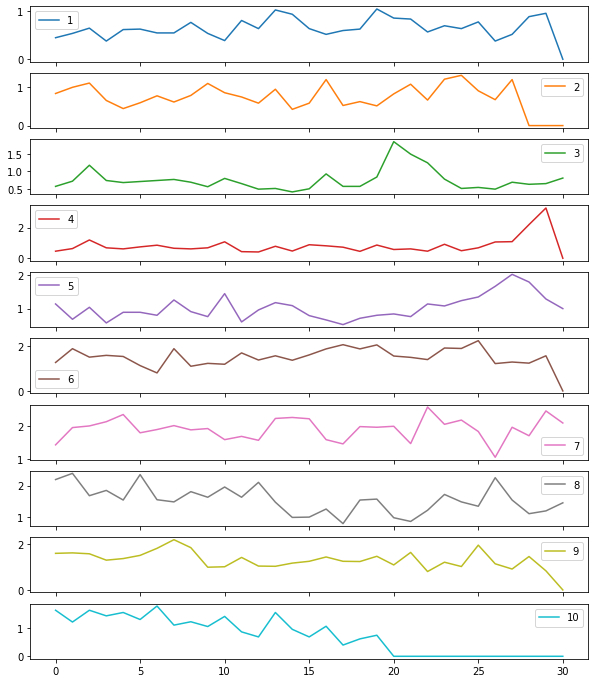

In [34]:
months.plot(subplots=True, legend=True, figsize=(10,12))

**Relationship between month and week**

From the first picture we can easily find the change of month and total_load. As can be seen from the figure, June, July, August and September are the peak periods. Described in the second picture is the relationship between hours and total_load. We can roughly see that the household's electricity consumption is very regular, and the peak period is concentrated in the afternoon. 

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


(<Figure size 900x122.4 with 2 Axes>,
 array([<AxesSubplot:ylabel='2018'>], dtype=object))

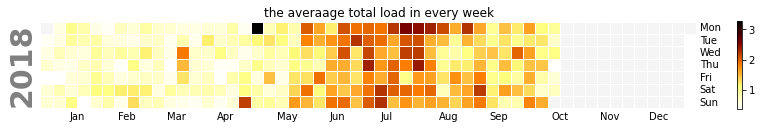

In [35]:
calplot.calplot(tenp['total_load'], edgecolor=None, cmap = 'afmhot_r',suptitle = 'the averaage total load in every week')

It can be seen from this thermal image that the week does not seem to have relationship between the total electricity consumption of the user.In addition, we also draw similar conclusions as above: month and electricity consumption are related by

### 3.1.3 Time Series Decomposition

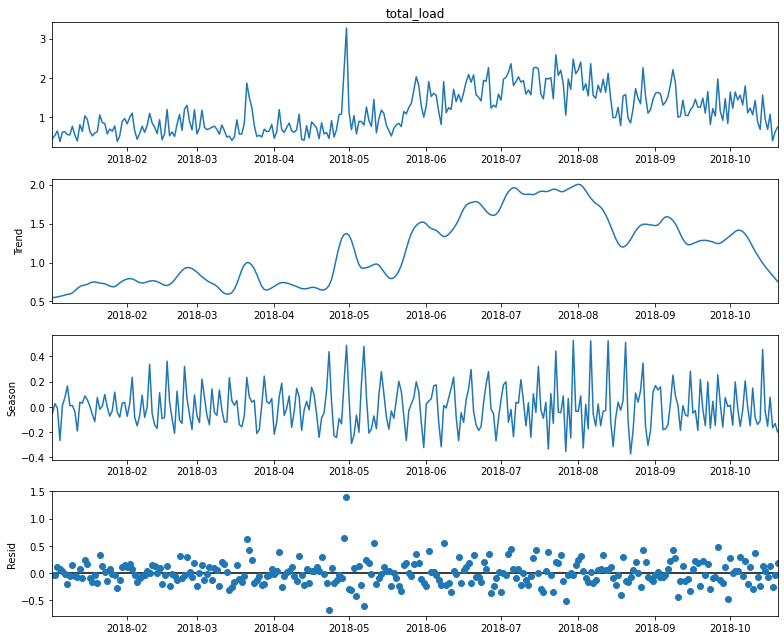

In [66]:
# https://towardsdatascience.com/different-types-of-time-series-decomposition-396c09f92693
# https://zhuanlan.zhihu.com/p/302325061 分解图
# https://betterprogramming.pub/a-visual-guide-to-time-series-decomposition-analysis-a1472bb9c930
from statsmodels.tsa.seasonal import STL
rcParams['figure.figsize'] = 11, 9 
res = STL(tenp['total_load']).fit()
res.plot()
plot.show()

In the time series, there are mainly three parts worthy of our attention: 
- Trend: The trend of a time series refers to the general direction in which the time series moves. From our trend graph, it is easy to find that our electricity consumption has a clear relationship with the month
- Seasonality: The period of time series data refers to its tendency to rise and fall at a consistent frequency. It can be roughly seen from our season chart that users actually rise and fall regularly in these 10 months, except for the peak electricity consumption period we mentioned above: August and September. But it's interesting to see that May was compared to peak electricity consumption by a similar trend.
- Remainder: The remainder is what’s left of the time series data after removing its trend, cycle, and seasonal components. As can be seen from the Raised chart, the reason why there will be a similar trend in May compared to August and September is because there are some outliers.

## 3.2 feature extraction

*After our data visualization part above, we can find that: month, day, hour and electricity consumption are related.*

### 3.2.1 add feature from the part 1

In [37]:
traditional_file['month'] = traditional_file['localminute'].map(lambda x:x.month)
# sunday is 0 
# traditional_file['week'] = traditional_file['localminute'].map(lambda x:x.dayofweek)
traditional_file['day'] = traditional_file['localminute'].map(lambda x:x.day)
traditional_file['hour'] = traditional_file['localminute'].map(lambda x:x.hour)
# del traditional_file['week']

In [38]:
# 分为白天黑夜
traditional_file['midnight'] = traditional_file['localminute'].dt.hour.isin(range(1,7)).astype(int)

Text(0.5, 1.0, 'the boxplot total_load for each month in 24 hours')

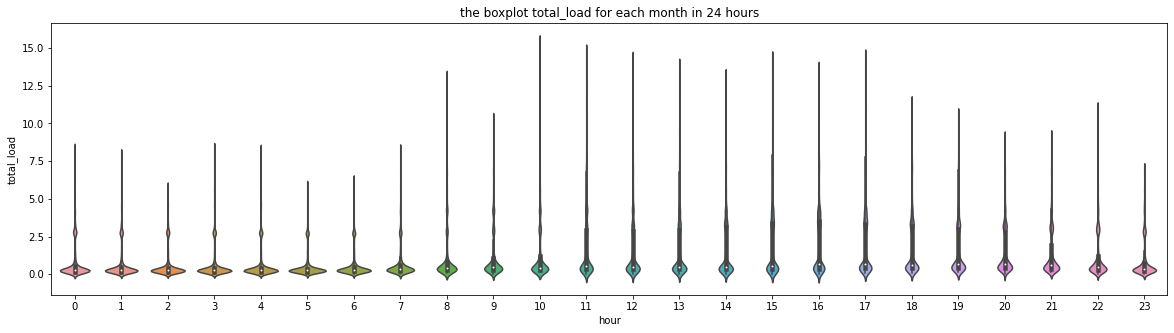

In [39]:
fig, ax = plot.subplots(1,1, figsize =(20,5))
ax = sns.violinplot(x="hour", y="total_load", data=traditional_file)
ax.set_title('the boxplot total_load for each month in 24 hours')

### 3.2.2 more research in a

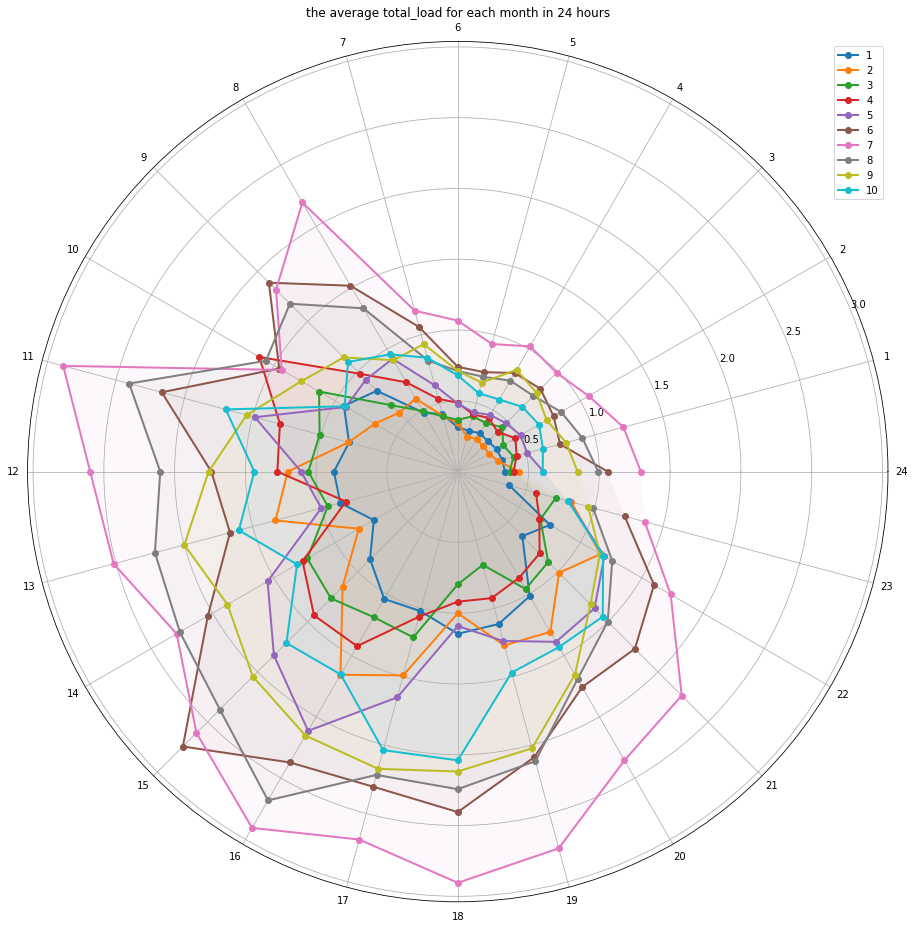

In [48]:
%matplotlib inline
Radar_file = traditional_file[['total_load','month','hour']].groupby(['month', 'hour']).mean()
Radar_name = list(set(traditional_file.hour))
Radar_name[0] = 24

angles=np.linspace(0,2*np.pi,len(Radar_name), endpoint=False)

fig=plot.figure(figsize=(13,13))
ax=fig.add_subplot(111, polar=True)
ax.set_title('the average total_load for each month in 24 hours')
for i in range(10):
    ax.plot(angles,Radar_file.total_load[i+1].values, 'o-', linewidth=2, label=i+1)
    ax.fill(angles, Radar_file.total_load[i+1].values, alpha=0.05)
ax.set_thetagrids(angles * 180/np.pi, Radar_name)
plot.grid(True)
plot.tight_layout()
plot.legend()

In [ ]:
# sang ?
# survery the average time to charge
traditional_file

In [ ]:
traditional_file

In [ ]:
# use to calcualte the average charge time and corresponding total_load time
from statistics import mean
def calculate_avg_load_charge(original_df):
    # save the charge time
    charge_time = []
    # save the corresponding total load values
    total_load_values = []
    # save the date informatin of current 
    flag = False
    # record the charge time of every time
    each_charge_time = 0
    each_total_load = []
    for index, row in original_df.iterrows():
        current_charge_time = row['target']
        if current_charge_time == 1 and flag is False:
            flag = True
        if flag is True and current_charge_time == 1:
            
            each_charge_time = each_charge_time + 1
            each_total_load.append(row['total_load']) 
        if current_charge_time == 0 and flag is True:
            
            flag = False
            charge_time.append(each_charge_time)
            total_load_values.append(mean(each_total_load))
            each_charge_time = 0
            each_total_load = []

    # return the result
    result = pd.DataFrame({'total_load': total_load_values, 'charge_time': charge_time})
    return result

In [ ]:
new_df

In [ ]:
new_df = calculate_avg_load_charge(traditional_file)

In [ ]:
new_df.describe()

According to the result shown above, it could be observed that the average charging time is 54.1 minutes. Also, it could be observed that the average total load when the EV is being charging is about 4.82, and **1/4 quantile** is about **4.15**. In this case, we would like to create a new column which is used to judge whether current total_load values is exceed the 1/4 quantile.

???添加is_高耗电量？？？？？中位数还是均值

In [ ]:
traditional_file['high_load'] = traditional_file.total_load.apply(lambda x: 1 if x>4.15 else 0)

In [ ]:
traditional_file

## 3. trainning model

In [ ]:
file['month'] = traditional_file['localminute'].map(lambda x:x.month)
# sunday is 0 
# traditional_file['week'] = traditional_file['localminute'].map(lambda x:x.dayofweek)
file['day'] = traditional_file['localminute'].map(lambda x:x.day)
file['hour'] = traditional_file['localminute'].map(lambda x:x.hour)

In [ ]:
file['midnight'] = traditional_file['localminute'].dt.hour.isin(range(1,7)).astype(int)

In [ ]:
train_data,test_data = train_test_split(file,train_size=0.8,shuffle=False)

train_label = train_data['target']
train_data = train_data.drop(['dataid','localminute','target'],axis=1)

test_label = test_data['target']
test_data = test_data.drop(['dataid','localminute','target'],axis=1)

In [ ]:
f1 = {}
precision = {}

### 3.1 KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=30)

knn.fit(train_data,train_label)
knn_prediction = knn.predict(test_data)
f1['knn'] = f1_score(test_label,knn_prediction)
precision['knn'] = precision_score(test_label,knn_prediction)

### 3.2 logestic

In [ ]:
lm = LogisticRegression()

lm.fit(train_data,train_label)
lm_prediction = lm.predict(test_data)
f1['lm'] = f1_score(test_label,lm_prediction)
precision['lm'] = precision_score(test_label,lm_prediction)

### 3.3 lgbm 

In [ ]:
lgbm = LGBMClassifier(num_leaves=31,n_estimators=1500,learning_rate=0.01)

lgbm.fit(train_data,train_label,eval_set=(test_data,test_label),verbose=50)
lgbm_prediction = lgbm.predict(test_data,num_iteration=lgbm.best_iteration_)
f1['lgbm'] = f1_score(test_label,lgbm_prediction)
precision['lgbm'] = precision_score(test_label,lgbm_prediction)

### 3.4 XGboost

In [ ]:
xgb = XGBClassifier()

xgb.fit(train_data,train_label)
xgb_prediction = xgb.predict(test_data)
f1['xgb'] = f1_score(test_label,xgb_prediction)
precision['xgb'] = precision_score(test_label,xgb_prediction)

### 3.5 MLP

In [ ]:
train_data

In [ ]:
from keras.layers.core import Dense, Dropout
from keras.optimizers import RMSprop
from keras.models import Sequential

model = Sequential()
model.add(Dense(units = 128, input_dim=11, activation='relu'))
model.add(Dropout(0.2))    
model.add(Dense(units = 64,  input_dim=11, activation='relu'))    
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'linear'))
model.summary()
model.compile(loss='mean_squared_error', optimizer=RMSprop(lr = 0.01))

model.fit(train_data.values,train_label.values, epochs=100, batch_size=50, verbose=50)

mlp_prediction = model.predict(test_data)

ttt = []
for i in mlp_prediction:
    if i>=0.5:
        ttt.append(1)
    else:
        ttt.append(0)

f1['mlp'] = f1_score(test_label,np.array(ttt))
precision['mlp'] = precision_score(test_label,np.array(ttt))

In [ ]:
f1

In [ ]:
precision